Imports and Configuration

In [33]:

import os 
import json 
import time
import numpy as np
import pandas as pd
import requests
import streamlit as st
from collections import Counter, defaultdict
from getpass import getpass

import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline

os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_FLAX"] = "1"

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity


st.set_page_config(page_title="Wesnoth PR Clustering", layout="wide")
st.title("Patch Patterns: Clustering Similar Pull Requests")


2025-10-27 16:03:37.695 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-27 16:03:37.697 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-27 16:03:37.698 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-27 16:03:37.698 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

Streamlit Configuration

In [34]:
st.set_page_config(page_title="Wesnoth PR Clustering", layout="wide")
st.title("Patch Patterns: Clustering Similar Pull Requests")

2025-10-27 16:03:37.726 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-27 16:03:37.728 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-27 16:03:37.730 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-27 16:03:37.730 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

Read GitHub token from Streamlit Secrets

In [35]:

GITHUB_TOKEN = st.secrets.get("GITHUB_TOKEN", "")
if not GITHUB_TOKEN:
    st.info("ℹ️ Add a GitHub token in Streamlit → Settings → Secrets as `GITHUB_TOKEN`.")


GitHub API helpers (cached)

In [36]:
@st.cache_data(show_spinner=False)
def gh_get(url: str, token: str, params: dict | None = None, accept: str | None = None):
    headers = {"Authorization": f"Bearer {token}"} if token else {}
    if accept: headers["Accept"] = accept
    r = requests.get(url, headers=headers, params=params, timeout=60)
    if r.status_code == 403 and "rate limit" in r.text.lower():
        reset = int(r.headers.get("X-RateLimit-Reset", time.time()+60))
        sleep_s = max(1, reset - int(time.time()) + 1)
        time.sleep(sleep_s)
        r = requests.get(url, headers=headers, params=params, timeout=60)
    r.raise_for_status()
    return r.json()


2025-10-27 16:03:37.766 No runtime found, using MemoryCacheStorageManager


In [37]:
@st.cache_data(show_spinner=True)
def fetch_merged_prs(owner: str, repo: str, target: int, token: str):
    GITHUB_API = "https://api.github.com"
    prs, page, per_page = [], 1, 100
    while len(prs) < target:
        url = f"{GITHUB_API}/repos/{owner}/{repo}/pulls"
        params = {"state": "closed", "per_page": per_page, "page": page, "sort": "updated", "direction": "desc"}
        batch = gh_get(url, token, params=params)
        if not batch: break
        merged = [pr for pr in batch if pr.get("merged_at")]
        prs.extend(merged)
        page += 1
        if len(batch) < per_page: break
    return prs[:target]



2025-10-27 16:03:37.783 No runtime found, using MemoryCacheStorageManager


Text building for embeddings

In [38]:
# --- Text block builder ---
def build_text_block(rec: dict) -> str:
    title = rec.get("title") or ""
    body = rec.get("body") or ""
    commits = "\n".join(rec.get("commits_messages") or [])
    files = rec.get("files") or []
    changed_paths = " ".join([f.get("filename","") for f in files])
    return f"TITLE: {title}\nBODY: {body}\nCOMMITS:\n{commits}\nFILES: {changed_paths}".strip()


In [39]:
@st.cache_data(show_spinner=True)
def fetch_pr_details(owner: str, repo: str, numbers: list[int], token: str):
    GITHUB_API = "https://api.github.com"
    out = []
    for n in numbers:
        files = gh_get(f"{GITHUB_API}/repos/{owner}/{repo}/pulls/{n}/files", token)
        commits = gh_get(f"{GITHUB_API}/repos/{owner}/{repo}/pulls/{n}/commits", token)
        pr = gh_get(f"{GITHUB_API}/repos/{owner}/{repo}/pulls/{n}", token)
        file_entries = [{
            "filename": f.get("filename"),
            "status": f.get("status"),
            "additions": f.get("additions"),
            "deletions": f.get("deletions"),
            "changes":  f.get("changes"),
            "patch":    f.get("patch"),
        } for f in files]
        commit_msgs = [c.get("commit", {}).get("message","") for c in commits]
        labels = [lab.get("name") for lab in pr.get("labels", [])]
        out.append({
            "number": pr.get("number"),
            "title": pr.get("title"),
            "user": pr.get("user", {}).get("login"),
            "state": pr.get("state"),
            "merged_at": pr.get("merged_at"),
            "created_at": pr.get("created_at"),
            "updated_at": pr.get("updated_at"),
            "labels": labels,
            "body": pr.get("body"),
            "files": file_entries,
            "commits_messages": commit_msgs,
            "html_url": pr.get("html_url"),
        })
    return out


2025-10-27 16:03:37.821 No runtime found, using MemoryCacheStorageManager


Embedding model loading and encoding (cached)

In [40]:
# --- Embedding (cached) ---
@st.cache_resource(show_spinner=True)
def load_embed_model(model_name: str):
    return SentenceTransformer(model_name)

@st.cache_data(show_spinner=True)
def embed_records(data: list[dict], model_name: str):
    texts = [build_text_block(r) for r in data]
    model = load_embed_model(model_name)
    emb = model.encode(texts, show_progress_bar=False, convert_to_numpy=True, normalize_embeddings=True)
    index_rows = [{
        "number": r.get("number"),
        "title": r.get("title"),
        "labels": ",".join(r.get("labels") or []),
        "url": r.get("html_url"),
    } for r in data]
    return emb, pd.DataFrame(index_rows), texts


2025-10-27 16:03:37.846 No runtime found, using MemoryCacheStorageManager


Clustering via threshold graph → connected components

In [41]:
# --- Clustering ---
def cluster_by_threshold(emb: np.ndarray, threshold: float):
    sim = cosine_similarity(emb)
    np.fill_diagonal(sim, 1.0)
    n = sim.shape[0]

    # Union-Find for connected components (faster than building NetworkX graph on large n)
    parent = list(range(n))
    rank = [0]*n
    def find(x):
        if parent[x]!=x: parent[x]=find(parent[x])
        return parent[x]
    def union(x,y):
        rx,ry = find(x),find(y)
        if rx==ry: return
        if rank[rx]<rank[ry]: parent[rx]=ry
        elif rank[rx]>rank[ry]: parent[ry]=rx
        else: parent[ry]=rx; rank[rx]+=1

    for i in range(n):
        row = sim[i, i+1:]
        js = np.where(row >= threshold)[0] + (i+1)
        for j in js: union(i,j)

    root_to_id, cid = {}, 0
    cluster_ids = np.zeros(n, dtype=int) - 1
    for i in range(n):
        r = find(i)
        if r not in root_to_id:
            root_to_id[r] = cid
            cid += 1
        cluster_ids[i] = root_to_id[r]
    return cluster_ids


Small utilities for preview and analysis

In [42]:
def top_title_tokens(df_with_titles: pd.DataFrame, max_tokens=8):
    import re
    rows = []
    grp = df_with_titles.groupby("cluster_id")
    for cid, g in grp:
        toks = []
        for t in g["title"].fillna(""):
            toks += [w for w in re.findall(r"[A-Za-z][A-Za-z0-9_+-]{2,}", t.lower())
                     if w not in {"the","and","for","with","into","from","this","that","fix","pr"}]
        common = " ".join([w for w,_ in Counter(toks).most_common(max_tokens)])
        rows.append({"cluster_id": cid, "n_items": len(g), "top_title_tokens": common})
    return pd.DataFrame(rows).sort_values("n_items", ascending=False)


In [43]:
def explode_labels(s: str) -> list[str]:
    if not isinstance(s, str) or not s.strip(): return []
    return [x.strip() for x in s.split(",") if x.strip()]

In [44]:
def path_counts_by_cluster(df_clusters: pd.DataFrame, num_to_record: dict[int, dict]):
    counts = defaultdict(Counter)
    for r in df_clusters.itertuples():
        rec = num_to_record.get(int(r.number))
        if not rec: continue
        for f in (rec.get("files") or []):
            fn = (f.get("filename") or "").strip()
            if fn:
                top = fn.split("/")[0] if "/" in fn else fn
                counts[r.cluster_id][top] += 1
    rows = []
    for cid, cnt in counts.items():
        for p, n in cnt.most_common(8):
            rows.append({"cluster_id": cid, "path": p, "count": n})
    return pd.DataFrame(rows)

Sidebar controls (owner/repo/target/model/threshold + buttons)

In [45]:
# --- Sidebar controls ---
st.sidebar.header("Settings")
owner = st.sidebar.text_input("GitHub Owner", value="wesnoth")
repo = st.sidebar.text_input("GitHub Repo", value="wesnoth")
target = st.sidebar.slider("Merged PRs to fetch", min_value=100, max_value=600, value=400, step=50)
model_name = st.sidebar.text_input("Embedding model", value="sentence-transformers/all-MiniLM-L6-v2")
threshold = st.sidebar.slider("Clustering threshold", min_value=0.70, max_value=0.98, value=0.92, step=0.01)

fetch_btn = st.sidebar.button("1) Fetch PRs")
embed_btn = st.sidebar.button("2) Embed")
cluster_btn = st.sidebar.button("3) Cluster & Analyze")


2025-10-27 16:03:37.934 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-27 16:03:37.935 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-27 16:03:37.936 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-27 16:03:37.937 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-27 16:03:37.938 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-27 16:03:37.939 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-27 16:03:37.939 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-27 16:03:37.940 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

Session state

In [46]:
# --- Session state store ---
if "raw_rows" not in st.session_state: st.session_state.raw_rows = None
if "index_df" not in st.session_state: st.session_state.index_df = None
if "emb" not in st.session_state: st.session_state.emb = None
if "cluster_df" not in st.session_state: st.session_state.cluster_df = None
if "text_blocks" not in st.session_state: st.session_state.text_blocks = None


2025-10-27 16:03:38.008 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-27 16:03:38.010 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-27 16:03:38.012 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-27 16:03:38.013 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-27 16:03:38.014 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Button actions (fetch → embed → cluster & analyze)

In [47]:
if fetch_btn:
    if not GITHUB_TOKEN:
        st.error("Please add `GITHUB_TOKEN` in your Streamlit app secrets.")
    else:
        st.info("Fetching merged PRs…")
        merged = fetch_merged_prs(owner, repo, target, GITHUB_TOKEN)
        numbers = [m["number"] for m in merged]
        rows = fetch_pr_details(owner, repo, numbers, GITHUB_TOKEN)
        st.session_state.raw_rows = rows
        st.success(f"Fetched {len(rows)} PRs.")
        st.dataframe(pd.DataFrame([{
            "number": r["number"], "title": r["title"], "labels": ", ".join(r.get("labels") or []), "url": r["html_url"]
        } for r in rows]).head(20))



In [48]:
if embed_btn:
    if not st.session_state.raw_rows:
        st.warning("Fetch PRs first.")
    else:
        st.info("Embedding PRs…")
        emb, index_df, texts = embed_records(st.session_state.raw_rows, model_name)
        st.session_state.emb = emb
        st.session_state.index_df = index_df
        st.session_state.text_blocks = texts
        st.success(f"Embeddings ready. Shape: {emb.shape}")
        st.dataframe(index_df.head(10))



In [49]:
if cluster_btn:
    if st.session_state.emb is None or st.session_state.index_df is None:
        st.warning("Run embedding first.")
    else:
        st.info("Clustering by threshold…")
        cids = cluster_by_threshold(st.session_state.emb, threshold)
        out = st.session_state.index_df.copy()
        out["cluster_id"] = cids
        st.session_state.cluster_df = out
        st.success("Clustering complete.")

        # Largest clusters
        st.subheader("Largest clusters")
        sizes = out.groupby("cluster_id")["number"].count().sort_values(ascending=False)
        st.write(sizes.head(20))

        # Preview keywords
        st.subheader("Cluster preview (top title tokens)")
        st.dataframe(top_title_tokens(out))

        # Labels per cluster
        st.subheader("Label heatmap rows (top labels per cluster)")
        label_rows = []
        grp = out.groupby("cluster_id")
        for cid, g in grp:
            cnt = Counter()
            for labs in g["labels"].fillna(""):
                cnt.update(explode_labels(labs))
            for lab, n in cnt.most_common(6):
                label_rows.append({"cluster_id": cid, "label": lab, "count": n})
        label_df = pd.DataFrame(label_rows)
        st.dataframe(label_df.head(40))

        # Path stats per cluster (uses original JSON)
        st.subheader("Path stats (top-level directories per cluster)")
        num_to_record = {r["number"]: r for r in st.session_state.raw_rows}
        path_df = path_counts_by_cluster(out, num_to_record)
        st.dataframe(path_df.head(40))


Similarity search

In [50]:
# --- Similarity search ---
st.header("Similarity Search")
query = st.text_area("Paste a new issue/PR description", height=180,
                     placeholder="e.g., Fix AI pathfinding bug in campaign X …")
topk = st.slider("Top K", 5, 30, 10)

if st.button("Search similar PRs"):
    if st.session_state.emb is None or st.session_state.index_df is None:
        st.warning("Please embed (step 2) first.")
    else:
        model = load_embed_model(model_name)
        qv = model.encode([query], convert_to_numpy=True, normalize_embeddings=True)
        sims = cosine_similarity(qv, st.session_state.emb)[0]
        order = np.argsort(-sims)[:topk]
        res = st.session_state.index_df.iloc[order].copy()
        res.insert(1, "similarity", sims[order])
        st.dataframe(res)
        for r in res.itertuples():
            st.markdown(f"**PR #{int(r.number)}** — [{r.title}]({r.url})  \nSimilarity: `{r.similarity:.3f}`  \nLabels: `{r.labels}`")


2025-10-27 16:03:38.086 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-27 16:03:38.088 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-27 16:03:38.089 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-27 16:03:38.091 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-27 16:03:38.092 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-27 16:03:38.093 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-27 16:03:38.095 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-27 16:03:38.096 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

Fetching and Preparing Pull Request Data from GitHub

In [51]:
OWNER, REPO, TARGET = "wesnoth", "wesnoth", 400
TOKEN = getpass("GitHub token: ")
API = "https://api.github.com"

def gh(url, params=None):
    h = {"Authorization": f"Bearer {TOKEN}"} if TOKEN else {}
    r = requests.get(url, headers=h, params=params, timeout=60)
    if r.status_code==403 and "rate limit" in r.text.lower():
        reset = int(r.headers.get("X-RateLimit-Reset", time.time()+60))
        time.sleep(max(1, reset-int(time.time())+1))
        r = requests.get(url, headers=h, params=params, timeout=60)
    r.raise_for_status()
    return r.json()

def fetch_merged_prs(owner, repo, target):
    out, page = [], 1
    while len(out)<target:
        batch = gh(f"{API}/repos/{owner}/{repo}/pulls",
                   {"state":"closed","per_page":100,"page":page,"sort":"updated","direction":"desc"})
        if not batch: break
        out += [pr for pr in batch if pr.get("merged_at")]
        page += 1
        if len(batch)<100: break
    return out[:target]

def details(owner, repo, num):
    files = gh(f"{API}/repos/{owner}/{repo}/pulls/{num}/files")
    commits = gh(f"{API}/repos/{owner}/{repo}/pulls/{num}/commits")
    pr = gh(f"{API}/repos/{owner}/{repo}/pulls/{num}")
    return {
        "number": pr["number"],
        "title": pr["title"],
        "labels": [x["name"] for x in pr.get("labels",[])],
        "body": pr.get("body"),
        "files": [{"filename": f.get("filename")} for f in files],
        "commits_messages": [c["commit"]["message"] for c in commits],
        "url": pr["html_url"]
    }



In [52]:

merged = fetch_merged_prs(OWNER, REPO, TARGET)
rows = [details(OWNER, REPO, pr["number"]) for pr in merged]
os.makedirs("data", exist_ok=True)
json.dump(rows, open("data/wesnoth_pr_data.json","w"), indent=2)
idx = pd.DataFrame([{"number":r["number"],"title":r["title"],
                     "labels":",".join(r["labels"]), "url":r["url"]} for r in rows])
idx.to_csv("data/wesnoth_index.csv", index=False)
idx.head()

,number,title,labels,url
0,10635,Fix shema cumulative= valide for no numerical ...,"Unit Tests,Units,Schema,Campaign DiD,Campaign ...",https://github.com/wesnoth/wesnoth/pull/10635
1,10641,Correct the schema validation disable in the w...,Unit Tests,https://github.com/wesnoth/wesnoth/pull/10641
2,10633,Sort terrain entries alphabetically.,"Help,Terrain",https://github.com/wesnoth/wesnoth/pull/10633
3,10537,Revert 'Balancing Update' to Dwarvish Miner,Units,https://github.com/wesnoth/wesnoth/pull/10537
4,10621,GUI2/Story Viewer: title text positioning supp...,"UI,Schema",https://github.com/wesnoth/wesnoth/pull/10621


In [53]:

def block(r):
    files = " ".join([f.get("filename","") for f in r.get("files",[])])
    cmts = "\n".join(r.get("commits_messages",[]))
    return f"TITLE: {r.get('title','')}\nBODY: {r.get('body','')}\nCOMMITS:\n{cmts}\nFILES: {files}"

data = json.load(open("data/wesnoth_pr_data.json"))
texts = [block(r) for r in data]
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
emb = model.encode(texts, convert_to_numpy=True, normalize_embeddings=True)



Threshold Clustering

In [54]:
def cluster(emb, thr=0.92):
    sim = cosine_similarity(emb); np.fill_diagonal(sim,1.0)
    n = sim.shape[0]
    parent = list(range(n)); rank=[0]*n
    def find(x):
        if parent[x]!=x: parent[x]=find(parent[x]); return parent[x]
        return x
    def union(a,b):
        ra,rb = find(a),find(b)
        if ra==rb: return
        if rank[ra]<rank[rb]: parent[ra]=rb
        elif rank[ra]>rank[rb]: parent[rb]=ra
        else: parent[rb]=ra; rank[ra]+=1
    for i in range(n):
        js = np.where(sim[i, i+1:]>=thr)[0]+(i+1)
        for j in js: union(i,j)
    roots = {}
    cid = np.full(n, -1)
    next_id=0
    for i in range(n):
        r = find(i)
        if r not in roots: roots[r]=next_id; next_id+=1
        cid[i]=roots[r]
    return cid

cids = cluster(emb, 0.92)
df = pd.read_csv("data/wesnoth_index.csv")
df["cluster_id"] = cids


Plot cluster sizes

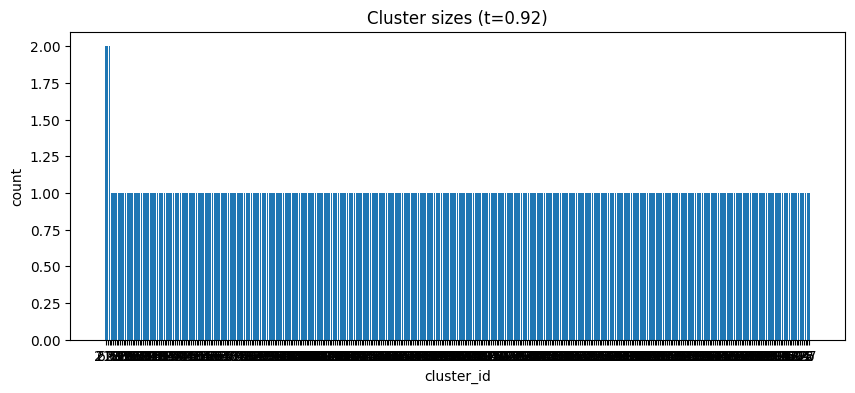

cluster_id
69     2
218    2
223    2
5      1
6      1
7      1
8      1
9      1
10     1
11     1
12     1
365    1
28     1
381    1
1      1
Name: number, dtype: int64

In [55]:
sizes = df.groupby("cluster_id")["number"].count().sort_values(ascending=False)
plt.figure(figsize=(10,4))
plt.bar(sizes.index.astype(str), sizes.values)
plt.title("Cluster sizes (t=0.92)"); plt.xlabel("cluster_id"); plt.ylabel("count")
plt.show()

sizes.head(15)

In [56]:
sizes.sort_values(ascending=False).head(10)


cluster_id
218    2
223    2
69     2
7      1
8      1
9      1
10     1
11     1
12     1
365    1
Name: number, dtype: int64

In [57]:
df[df["cluster_id"] == 68][["number", "title", "labels", "url"]]


,number,title,labels,url
68,10541,Use the default music playlist for Dark Foreca...,MP,https://github.com/wesnoth/wesnoth/pull/10541


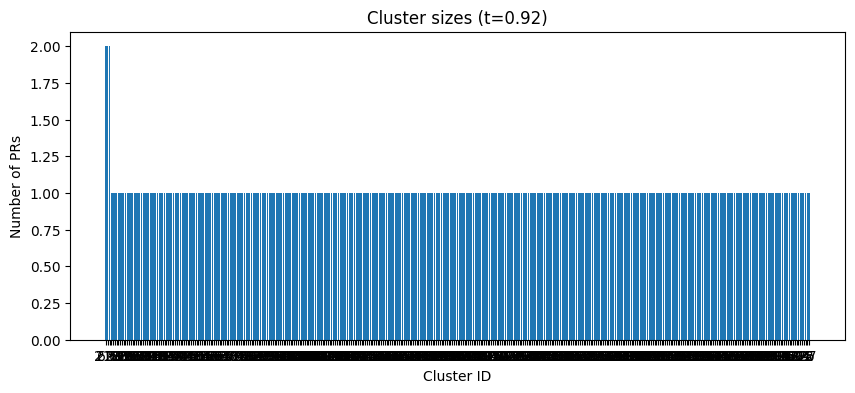

In [58]:

plt.figure(figsize=(10,4))
plt.bar(sizes.index.astype(str), sizes.values)
plt.title("Cluster sizes (t=0.92)")
plt.xlabel("Cluster ID")
plt.ylabel("Number of PRs")
plt.show()


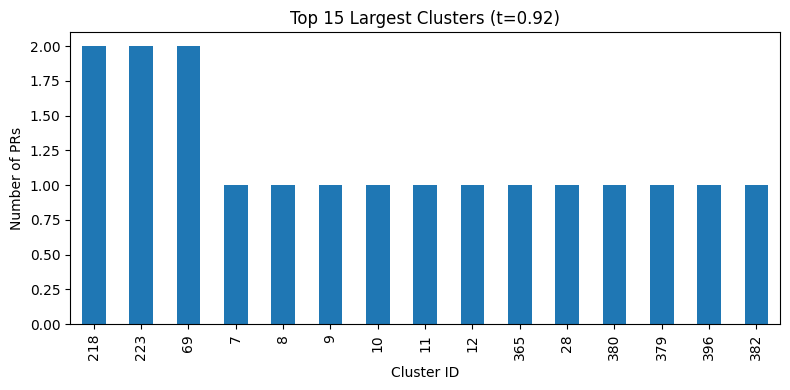

In [59]:
import matplotlib.pyplot as plt

top_n = 15
top_sizes = sizes.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(8, 4))
top_sizes.plot(kind='bar')
plt.title(f"Top {top_n} Largest Clusters (t=0.92)")
plt.xlabel("Cluster ID")
plt.ylabel("Number of PRs")
plt.tight_layout()
plt.show()


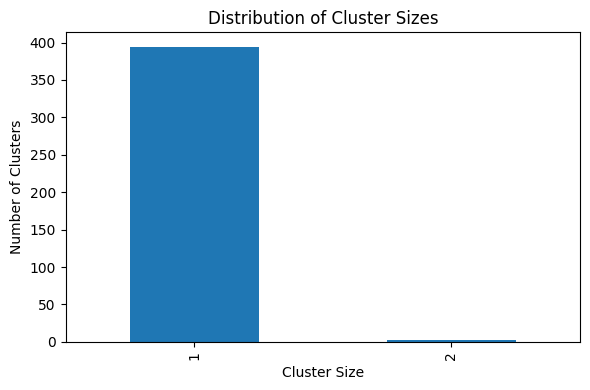

In [60]:
plt.figure(figsize=(6, 4))
sizes.value_counts().sort_index().plot(kind='bar')
plt.title("Distribution of Cluster Sizes")
plt.xlabel("Cluster Size")
plt.ylabel("Number of Clusters")
plt.tight_layout()
plt.show()


In [61]:
print("Total clusters:", len(sizes))
print("Single-PR clusters:", (sizes==1).sum())
print("Multi-PR clusters:", (sizes>1).sum())
print("Largest cluster size:", sizes.max())


Total clusters: 397
Single-PR clusters: 394
Multi-PR clusters: 3
Largest cluster size: 2
